In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline
import time
from typing import List, Optional
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression


%matplotlib inline

import warnings
warnings.simplefilter("ignore")


import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from boostaroota import BoostARoota

import shap
shap.initjs()

In [3]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')
df_bki = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/bki.csv')
df_client_profile = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv')
df_payments = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/payments.csv')


In [4]:
def reduce_mem_usage(X):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = X.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in X.columns:
        col_type = X[col].dtype
        
        if col_type != object:
            c_min = X[col].min()
            c_max = X[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    X[col] = X[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    X[col] = X[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    X[col] = X[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    X[col] = X[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     X[col] = X[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    X[col] = X[col].astype(np.float32)
                else:
                    X[col] = X[col].astype(np.float64)
        else:
            X[col] = X[col].astype('category')

    end_mem = X.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return X

In [5]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_application = reduce_mem_usage(df_application)
df_bki = reduce_mem_usage(df_bki)
df_client_profile = reduce_mem_usage(df_client_profile)
df_payments = reduce_mem_usage(df_payments)

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.63 MB
Decreased by 75.0%
Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.79 MB
Decreased by 68.7%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 114.69 MB
Decreased by 65.4%
Memory usage of dataframe is 122.60 MB
Memory usage after optimization is: 48.68 MB
Decreased by 60.3%
Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 18.12 MB
Decreased by 60.4%
Memory usage of dataframe is 62.50 MB
Memory usage after optimization is: 29.30 MB
Decreased by 53.1%


In [6]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   APPLICATION_NUMBER  110093 non-null  int32   
 1   TARGET              110093 non-null  int8    
 2   NAME_CONTRACT_TYPE  110093 non-null  category
dtypes: category(1), int32(1), int8(1)
memory usage: 645.3 KB


In [8]:
df_test.head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   APPLICATION_NUMBER  165141 non-null  int32   
 1   NAME_CONTRACT_TYPE  165141 non-null  category
dtypes: category(1), int32(1)
memory usage: 806.6 KB


трейн и тест без пропусков. любопытный момент, что в тесте данных больше, чем в трейне. 

In [10]:
df_application.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430054,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615234,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735352,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335938,450000.0,470790.0,NaN,450000.0,Approved,512,...,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.394531,337500.0,404055.0,NaN,337500.0,Refused,781,...,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int32   
 1   APPLICATION_NUMBER         1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE         940717 non-null   category
 3   AMOUNT_ANNUITY             1297979 non-null  float32 
 4   AMT_APPLICATION            1670214 non-null  float32 
 5   AMOUNT_CREDIT              1670213 non-null  float32 
 6   AMOUNT_PAYMENT             774370 non-null   float32 
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float32 
 8   NAME_CONTRACT_STATUS       1670214 non-null  category
 9   DAYS_DECISION              1670214 non-null  int16   
 10  NAME_PAYMENT_TYPE          1670214 non-null  category
 11  CODE_REJECT_REASON         1670214 non-null  category
 12  NAME_TYPE_SUITE            849809 non-null   category
 1

In [12]:
df_bki.head()

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.810547,0,675000.00000,320265.5,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.000000,0,93111.65625,0.0,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00000,0.0,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00000,37858.5,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00000,0.0,0.0,0.0,Credit card,116.0,NaN


In [13]:
df_bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   APPLICATION_NUMBER      945234 non-null  int32   
 1   BUREAU_ID               945234 non-null  int32   
 2   CREDIT_ACTIVE           945234 non-null  category
 3   CREDIT_CURRENCY         945234 non-null  category
 4   DAYS_CREDIT             945234 non-null  float32 
 5   CREDIT_DAY_OVERDUE      945234 non-null  int16   
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float32 
 7   DAYS_ENDDATE_FACT       596274 non-null  float32 
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float32 
 9   CNT_CREDIT_PROLONG      945234 non-null  int8    
 10  AMT_CREDIT_SUM          945229 non-null  float32 
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float32 
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float32 
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float32 
 14  CRED

In [14]:
df_client_profile.head()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [15]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   APPLICATION_NUMBER          250000 non-null  int32   
 1   GENDER                      250000 non-null  category
 2   CHILDRENS                   250000 non-null  int8    
 3   TOTAL_SALARY                250000 non-null  float32 
 4   AMOUNT_CREDIT               250000 non-null  float32 
 5   AMOUNT_ANNUITY              249989 non-null  float32 
 6   EDUCATION_LEVEL             250000 non-null  category
 7   FAMILY_STATUS               250000 non-null  category
 8   REGION_POPULATION           250000 non-null  float32 
 9   AGE                         250000 non-null  int16   
 10  DAYS_ON_LAST_JOB            250000 non-null  int32   
 11  OWN_CAR_AGE                 85041 non-null   float32 
 12  FLAG_PHONE                  250000 non-null  int8    
 13 

In [16]:
df_payments.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615234,12156.615234
1,48683432,123497205,1.0,13,442.0,432.0,18392.535156,10047.644531
2,48652024,123749925,1.0,10,8.0,23.0,5499.944824,5499.944824
3,48398897,123550846,0.0,82,398.0,398.0,7082.145020,7082.145020
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735001,156.735001


In [17]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int32  
 1   APPLICATION_NUMBER       1023932 non-null  int32  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float32
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int16  
 4   DAYS_INSTALMENT          1023932 non-null  float32
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float32
 6   AMT_INSTALMENT           1023932 non-null  float32
 7   AMT_PAYMENT              1023729 non-null  float32
dtypes: float32(5), int16(1), int32(2)
memory usage: 29.3 MB


In [18]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'))


In [19]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123687442,0,Cash,49915814,NaN,6510.015137,71668.796875,64500.300781,7168.500000,71668.796875,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
1,123687442,0,Cash,49713743,NaN,9262.214844,72634.140625,70758.000000,7267.140137,72634.140625,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
2,123687442,0,Cash,49704707,NaN,7339.185059,62058.601562,67518.000000,3.600000,62058.601562,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0
3,123597908,1,Cash,48716994,Cash,38667.601562,495000.000000,672948.000000,NaN,495000.000000,...,x-sell,-1,36.0,high,NaN,NaN,NaN,NaN,NaN,NaN
4,123597908,1,Cash,49672074,NaN,11349.900391,75510.000000,82156.500000,0.000000,75510.000000,...,XNA,12,10.0,high,365243.0,690.0,420.0,420.0,413.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516110,123723001,0,Cash,49650758,NaN,4998.645020,34245.000000,27207.000000,8563.500000,34245.000000,...,XNA,156,6.0,low_normal,365243.0,160.0,10.0,40.0,34.0,1.0
516111,123723001,0,Cash,49065356,NaN,3001.949951,26482.500000,29281.500000,0.000000,26482.500000,...,XNA,156,12.0,middle,365243.0,708.0,378.0,558.0,526.0,0.0
516112,123554358,0,Cash,49515687,NaN,20264.804688,261180.000000,287037.000000,0.000000,261180.000000,...,XNA,100,18.0,middle,365243.0,815.0,305.0,305.0,303.0,0.0
516113,123554358,0,Cash,49102720,Cash,29256.615234,337500.000000,368685.000000,NaN,337500.000000,...,walk-in,32,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
239762,49915814,123687442,NaN,6510.015137,71668.796875,64500.300781,7168.500000,71668.796875,Approved,240,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
509872,49713743,123687442,NaN,9262.214844,72634.140625,70758.000000,7267.140137,72634.140625,Approved,2702,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
626049,49704707,123687442,NaN,7339.185059,62058.601562,67518.000000,3.600000,62058.601562,Approved,721,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0


мы видим, что к одному номеру заявки относится несколько история из нескольких заявок, которую нужно дополнительно обработать. иначе таблица трейна и теста у нас разбухает от данных. пока оставим ее, попробуем объединить с другими таблицами.

In [21]:
df_train_merged = pd.merge(df_train, df_bki, on=('APPLICATION_NUMBER'))


In [22]:
df_train_merged.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123687442,0,Cash,5640206,Closed,currency 1,2562.0,0,2197.0,2162.0,4714.424805,0,56362.50000,0.0,0.0,0.0,Consumer credit,2162.0,NaN
1,123597908,1,Cash,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.00000,0.0,NaN,0.0,Consumer credit,731.0,NaN
2,123597908,1,Cash,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000000,0,137910.59375,0.0,0.0,0.0,Consumer credit,126.0,NaN
3,123597908,1,Cash,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.50000,181561.5,0.0,0.0,Consumer credit,10.0,NaN
4,123597908,1,Cash,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.00000,0.0,NaN,0.0,Consumer credit,83.0,NaN


In [23]:
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
14729,123597908,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.00000,0.0,NaN,0.0,Consumer credit,731.0,NaN
31667,123597908,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000000,0,137910.59375,0.0,0.0,0.0,Consumer credit,126.0,NaN
57336,123597908,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.50000,181561.5,0.0,0.0,Consumer credit,10.0,NaN
540054,123597908,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.00000,0.0,NaN,0.0,Consumer credit,83.0,NaN
758192,123597908,5974372,Active,currency 1,150.0,0,215.0,NaN,0.000000,0,106200.00000,76248.0,0.0,0.0,Consumer credit,27.0,NaN
772547,123597908,5990570,Closed,currency 1,1832.0,0,1745.0,1042.0,NaN,0,21829.50000,NaN,NaN,0.0,Consumer credit,1039.0,NaN
820607,123597908,5898408,Active,currency 1,57.0,0,127.0,NaN,0.000000,0,63202.50000,53667.0,0.0,0.0,Consumer credit,24.0,NaN
853827,123597908,5980412,Active,currency 1,1630.0,0,1326.0,NaN,16639.154297,0,162400.50000,0.0,0.0,0.0,Consumer credit,27.0,NaN
896743,123597908,5964293,Closed,currency 1,560.0,0,195.0,181.0,17985.914062,0,178650.00000,0.0,0.0,0.0,Consumer credit,181.0,NaN


данных по предыдущим кредитам также может быть несколько на каждый номер заявки. 

In [24]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [25]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


Здесь обратная картина - части данных из теста нет в базе профилей, поэтому размер данных стал меньше на 20000 наблюдений. Можно их попробовать заполнить, но качество данных от этого не увеличится. Поэтому ими лучше пренебречь

In [26]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'))


In [27]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123526683,0,Cash,F,0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
2,123710391,1,Cash,M,0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
3,123718821,0,Cash,F,1,180000.0,755190.0,36459.0,Secondary / secondary special,Married,...,3.0,NaN,0.548504,0.331251,1.0,0.0,0.0,0.0,0.0,2.0
4,123544624,0,Cash,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Married,...,2.0,NaN,0.547421,0.740799,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89534,123595479,0,Cash,F,0,225000.0,990432.0,32863.5,Secondary / secondary special,Separated,...,1.0,0.768198,0.713399,0.529890,0.0,0.0,0.0,0.0,0.0,0.0
89535,123426326,0,Cash,F,2,135000.0,995643.0,32904.0,Secondary / secondary special,Married,...,4.0,0.410920,0.592042,0.570917,0.0,0.0,0.0,0.0,0.0,1.0
89536,123672463,0,Cash,F,0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
89537,123554358,0,Cash,F,2,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [28]:
df_train_merged = pd.merge(df_train, df_payments, on=('APPLICATION_NUMBER'))


In [29]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,49796018,1.0,4,2830.0,2830.0,3289.635010,3289.635010
1,123687442,0,Cash,49796018,1.0,7,2740.0,2740.0,3289.635010,3289.635010
2,123687442,0,Cash,49713743,1.0,5,2551.0,2547.0,9262.214844,9251.865234
3,123687442,0,Cash,49713743,1.0,7,2491.0,2519.0,9262.214844,10.350000
4,123597908,1,Cash,49672074,1.0,9,450.0,457.0,11349.900391,11349.900391
...,...,...,...,...,...,...,...,...,...,...
316934,123672463,0,Cash,48886788,1.0,1,160.0,186.0,3135.239990,13500.000000
316935,123672463,0,Cash,48503461,1.0,3,1439.0,1433.0,4323.509766,4321.529785
316936,123723001,0,Cash,49650758,1.0,4,70.0,83.0,4998.645020,4998.645020
316937,123676265,0,Credit Card,49159579,1.0,5,2431.0,2443.0,15902.910156,15902.910156


In [30]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
65196,49796018,123687442,1.0,4,2830.0,2830.0,3289.635010,3289.635010
79322,49796018,123687442,1.0,7,2740.0,2740.0,3289.635010,3289.635010
693273,49713743,123687442,1.0,5,2551.0,2547.0,9262.214844,9251.865234
726215,49713743,123687442,1.0,7,2491.0,2519.0,9262.214844,10.350000


In [31]:
df_application = df_application.groupby(['APPLICATION_NUMBER']).mean().reset_index()

#df_application[df_application['APPLICATION_NUMBER'] == 123687442]

In [32]:
df_application

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123423340,4.863791e+07,3951.000000,24835.500,23787.00,2520.00,24835.500,1740.000,23.000,8.00,365243.0,1709.000000,1499.000000,1619.000000,1612.000000,0.000000
1,123423341,4.830703e+07,9251.775391,179055.000,179055.00,0.00,179055.000,606.000,500.000,24.00,365243.0,565.000000,125.000000,25.000000,17.000000,0.000000
2,123423342,4.954936e+07,56553.988281,435436.500,484191.00,3442.50,435436.500,1305.000,533.000,10.00,365243.0,1274.333374,1004.333313,1054.333374,1047.333374,0.666667
3,123423343,4.883223e+07,5357.250000,24282.000,20106.00,4860.00,24282.000,815.000,30.000,4.00,365243.0,784.000000,694.000000,724.000000,714.000000,0.000000
4,123423344,4.944505e+07,4813.200195,22308.750,20076.75,4464.00,44617.500,536.000,18.000,12.00,365243.0,706.000000,376.000000,466.000000,460.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,123779590,4.951623e+07,6605.910156,40455.000,40455.00,0.00,40455.000,273.000,30.000,8.00,365243.0,210.000000,0.000000,30.000000,25.000000,0.000000
338853,123779591,4.877181e+07,10074.464844,57595.500,56821.50,3456.00,57595.500,2497.000,190.000,6.00,365243.0,2466.000000,2316.000000,2316.000000,2311.000000,1.000000
338854,123779592,4.894544e+07,4770.404785,24162.750,20625.75,4403.25,24162.750,2380.000,22.000,5.00,365243.0,2339.000000,2219.000000,2219.000000,2212.500000,0.500000
338855,123779593,4.917287e+07,10681.131836,121317.750,134439.75,0.00,121317.750,299.500,1578.000,15.00,365243.0,269.000000,151.000000,365243.000000,365243.000000,0.500000


In [33]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
251104,123687442,49778088.0,7703.805176,68787.179688,67592.101562,4813.080078,68787.179688,1221.0,86.666667,10.666667,365243.0,1168.0,1002.666687,122688.0,122675.335938,0.333333


In [34]:
df_application = df_application.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [35]:
df_bki = df_bki.groupby(['APPLICATION_NUMBER']).mean().reset_index()
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
133899,123597908,5.951894e+06,869.555542,0.0,613.777771,590.799988,6925.013672,0.0,142799.40625,38934.5625,0.0,0.0,249.777771,NaN


In [36]:
df_bki = df_bki.drop(['BUREAU_ID'], axis=1)

In [37]:
df_payments = df_payments.groupby(['APPLICATION_NUMBER']).mean().reset_index()


In [38]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
195985,123687442,49754880.5,1.0,5.75,2653.0,2659.0,6275.924805,3960.371338


In [39]:
df_payments = df_payments.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [40]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [41]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,7703.805176,68787.179688,67592.101562,4813.080078,68787.179688,1221.000000,86.666667,...,1.0,0.0,0.0,2.0,1.000000,5.750000,2653.000000,2659.0,6275.924805,3960.371338
1,123597908,1,Cash,27919.001953,331908.750000,434949.750000,0.000000,331908.750000,659.250000,38.750000,...,NaN,NaN,NaN,NaN,1.000000,9.000000,450.000000,457.0,11349.900391,11349.900391
2,123526683,0,Cash,32538.476562,353857.500000,402818.250000,18814.500000,707715.000000,1423.166667,16.833333,...,0.0,7.0,0.0,4.0,0.500000,10.000000,1917.250000,1917.5,20169.472656,20169.472656
3,123710391,1,Cash,4237.694824,61206.750000,59661.000000,2250.000000,61206.750000,1151.500000,2058.500000,...,0.0,0.0,0.0,0.0,1.000000,2.000000,1843.000000,1854.0,2450.114990,2450.114990
4,123590329,1,Cash,14583.623047,266842.000000,308073.500000,1462.500000,300197.250000,741.000000,55.777778,...,NaN,NaN,NaN,NaN,1.000000,3.750000,1218.500000,1233.5,10608.389648,10608.389648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,13051.197266,66922.867188,74327.398438,0.832500,66922.867188,1308.200000,1126.600000,...,NaN,NaN,NaN,NaN,1.000000,6.000000,2296.000000,2309.0,4725.629883,4725.629883
110089,123672463,0,Cash,9349.533203,68150.523438,67411.382812,6643.649902,88595.687500,584.846154,26.692308,...,0.0,0.0,0.0,2.0,0.833333,5.833333,795.166687,789.5,6097.012695,6373.665039
110090,123723001,0,Cash,4000.297363,30363.750000,28244.250000,4281.750000,30363.750000,464.500000,156.000000,...,NaN,NaN,NaN,NaN,1.000000,4.000000,70.000000,83.0,4998.645020,4998.645020
110091,123554358,0,Cash,24760.710938,299340.000000,327861.000000,0.000000,299340.000000,789.000000,66.000000,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_test_merged = pd.merge(df_test, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [43]:
df_test_merged

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123724268,Cash,16837.808594,143007.750000,143007.750000,0.000000,286015.500000,514.500000,36.750000,6.000000,...,0.0,0.0,1.0,4.0,1.00,7.500000,494.000000,504.000000,11175.615234,11175.615234
1,123456549,Cash,26243.728516,321183.593750,393309.000000,1.170000,321183.593750,729.500000,67.000000,24.000000,...,1.0,0.0,0.0,2.0,2.50,53.500000,481.000000,474.000000,24610.386719,24610.386719
2,123428178,Credit Card,32940.507812,386057.250000,438194.250000,3304.125000,386057.250000,1078.250000,214.625000,15.500000,...,0.0,0.0,1.0,6.0,1.00,16.000000,556.000000,555.000000,49626.000000,49626.000000
3,123619984,Cash,13925.384766,397755.000000,357979.500000,39775.500000,397755.000000,637.000000,25.000000,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,Cash,7451.520020,50146.957031,45373.429688,7230.285156,62683.695312,1294.400000,1176.600000,9.333333,...,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,13829.872070,82500.000000,98340.000000,NaN,247500.000000,219.666667,-1.000000,24.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,Cash,18183.599609,181498.500000,163347.750000,18150.750000,181498.500000,269.000000,65.000000,10.000000,...,0.0,0.0,0.0,0.0,1.00,8.000000,163.000000,171.000000,24291.720703,24291.720703
165138,123718238,Cash,19887.287109,231750.000000,260080.656250,0.000000,257500.000000,1834.900000,-0.700000,16.799999,...,NaN,NaN,NaN,NaN,0.45,40.300000,1465.650024,1477.449951,22731.736328,21749.148438
165139,123631557,Cash,20090.880859,260456.781250,303534.000000,2322.000000,260456.781250,1149.428571,18.571429,23.142857,...,NaN,NaN,NaN,NaN,1.00,11.900000,687.000000,693.799988,20494.773438,18511.460938


Объединение таблиц завершено, теперь можно приступить к анализу данных. 

In [44]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])

print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features 54


Index(['APPLICATION_NUMBER', 'TARGET', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
      

In [45]:
categorical_features = df_train_merged.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.tail(n=5)

Categorical Feature Count 0


""
110088
110089
110090
110091
110092


<AxesSubplot:>

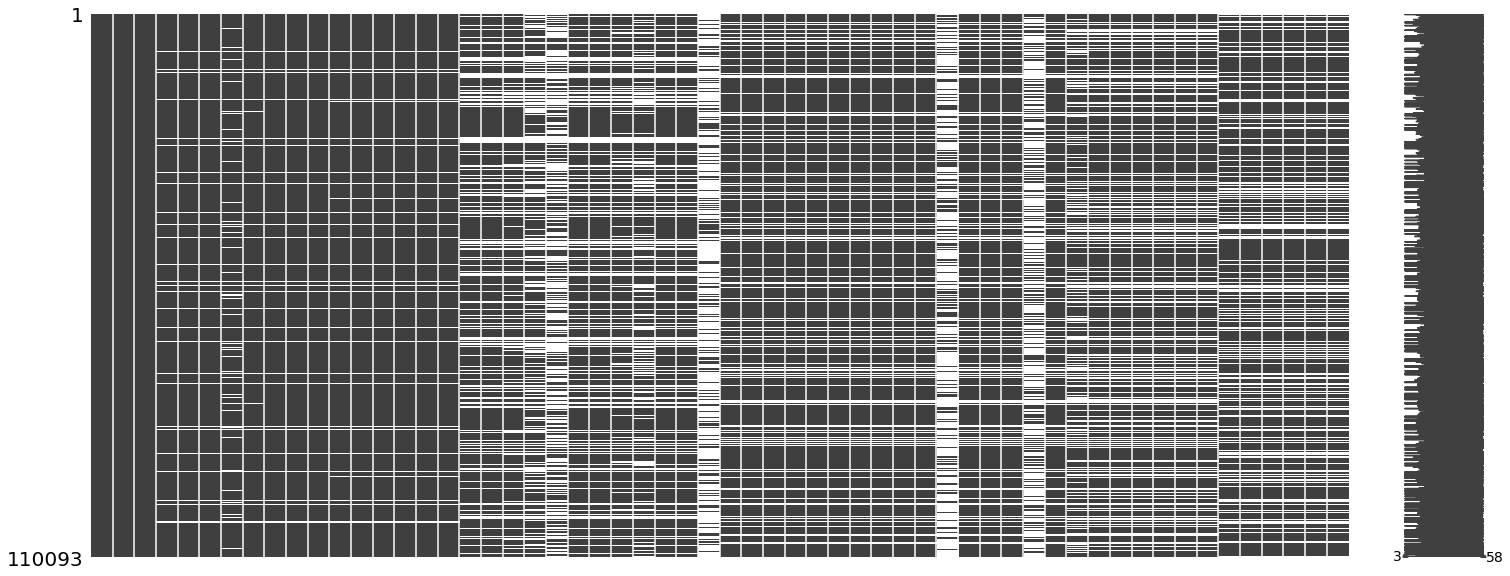

In [46]:
msno.matrix(df_train_merged)

In [47]:
df_train_merged.columns[df_train_merged.isnull().any()]

Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [48]:
df_test_merged.columns[df_test_merged.isnull().any()]


Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [49]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [50]:
check_missings(df_train_merged)

Total NA-values = 1352380


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Total,0,0,0,5576,5437,5437,11691,5751,5437,5437,...,32613,32613,32613,32613,28126,28126,28126,28128,28126,28128
Percent,0,0,0,5.06481,4.93855,4.93855,10.6192,5.22377,4.93855,4.93855,...,29.6231,29.6231,29.6231,29.6231,25.5475,25.5475,25.5475,25.5493,25.5475,25.5493
Types,int32,int8,category,float32,float32,float32,float32,float32,float64,float64,...,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32


In [51]:
check_missings(df_test_merged)

Total NA-values = 2035914


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Total,0,0,8270,8057,8057,17325,8540,8057,8057,8270,...,49104,49104,49104,49104,42568,42568,42568,42574,42568,42574
Percent,0,0,5.00784,4.87886,4.87886,10.491,5.17134,4.87886,4.87886,5.00784,...,29.7346,29.7346,29.7346,29.7346,25.7768,25.7768,25.7768,25.7804,25.7768,25.7804
Types,int32,category,float32,float32,float32,float32,float32,float64,float64,float32,...,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32


In [52]:
df_train_merged["TARGET"].unique()


array([0, 1], dtype=int8)

In [53]:
df_train_merged["TARGET"].value_counts()


0    101196
1      8897
Name: TARGET, dtype: int64

Целевое значение очень мало представлено, всего 9% процентов от общего количества

In [54]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 58 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   APPLICATION_NUMBER          110093 non-null  int32   
 1   TARGET                      110093 non-null  int8    
 2   NAME_CONTRACT_TYPE          110093 non-null  category
 3   AMOUNT_ANNUITY_x            104517 non-null  float32 
 4   AMT_APPLICATION             104656 non-null  float32 
 5   AMOUNT_CREDIT_x             104656 non-null  float32 
 6   AMOUNT_PAYMENT              98402 non-null   float32 
 7   AMOUNT_GOODS_PAYMENT        104342 non-null  float32 
 8   DAYS_DECISION               104656 non-null  float64 
 9   SELLERPLACE_AREA            104656 non-null  float64 
 10  CNT_PAYMENT                 104518 non-null  float32 
 11  DAYS_FIRST_DRAWING          104176 non-null  float32 
 12  DAYS_FIRST_DUE              104176 non-null  float32 
 13 

In [55]:
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165141 entries, 0 to 165140
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   APPLICATION_NUMBER          165141 non-null  int32   
 1   NAME_CONTRACT_TYPE          165141 non-null  category
 2   AMOUNT_ANNUITY_x            156871 non-null  float32 
 3   AMT_APPLICATION             157084 non-null  float32 
 4   AMOUNT_CREDIT_x             157084 non-null  float32 
 5   AMOUNT_PAYMENT              147816 non-null  float32 
 6   AMOUNT_GOODS_PAYMENT        156601 non-null  float32 
 7   DAYS_DECISION               157084 non-null  float64 
 8   SELLERPLACE_AREA            157084 non-null  float64 
 9   CNT_PAYMENT                 156871 non-null  float32 
 10  DAYS_FIRST_DRAWING          156403 non-null  float32 
 11  DAYS_FIRST_DUE              156403 non-null  float32 
 12  DAYS_LAST_DUE_1ST_VERSION   156403 non-null  float32 
 13 

Text(0, 0.5, 'count')

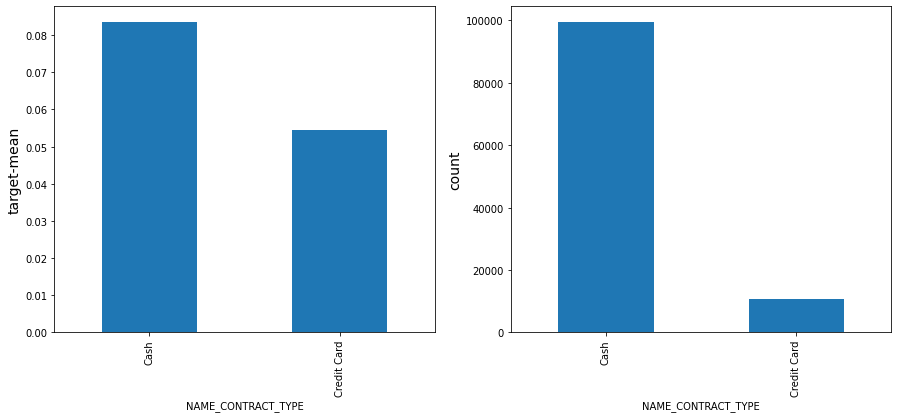

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

видим, что тип кредита cradit card имеет большую значимость, т.к. при меньшем количестве в среднем не сильно уступает наличным.

Text(0, 0.5, 'count')

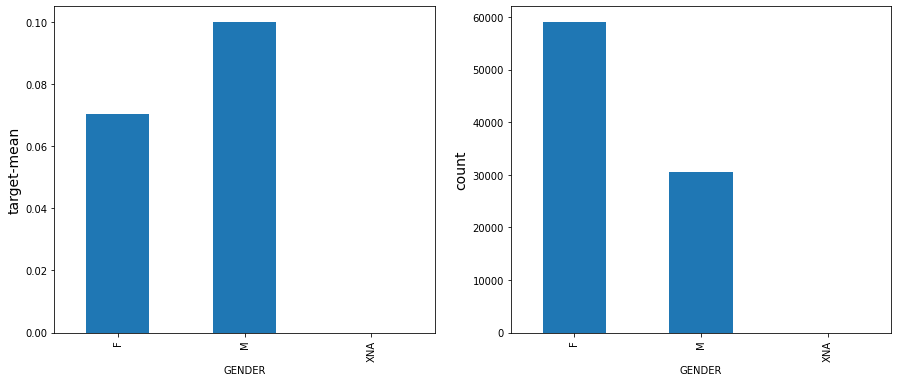

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

In [58]:
#в данных по полу есть третья графа, пустая. используем ее для пропусков
df_train_merged['GENDER'].fillna('XNA', inplace=True)


Text(0, 0.5, 'count')

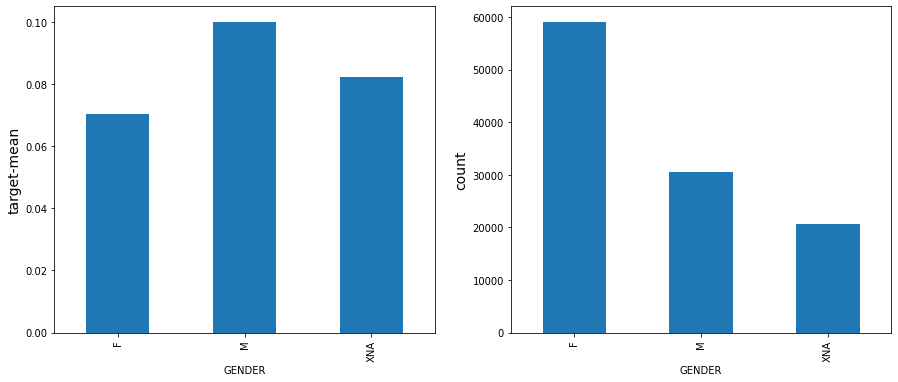

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

мужчин меньше, но они сильнее связаны с целевой переменной. При этом, мы видим, что количество пропусков также сильно связано с целевой переменной. Это означает, что либо это мужчины, либо в пропуски попали все связанные с целевым значением женщины

Text(0, 0.5, 'count')

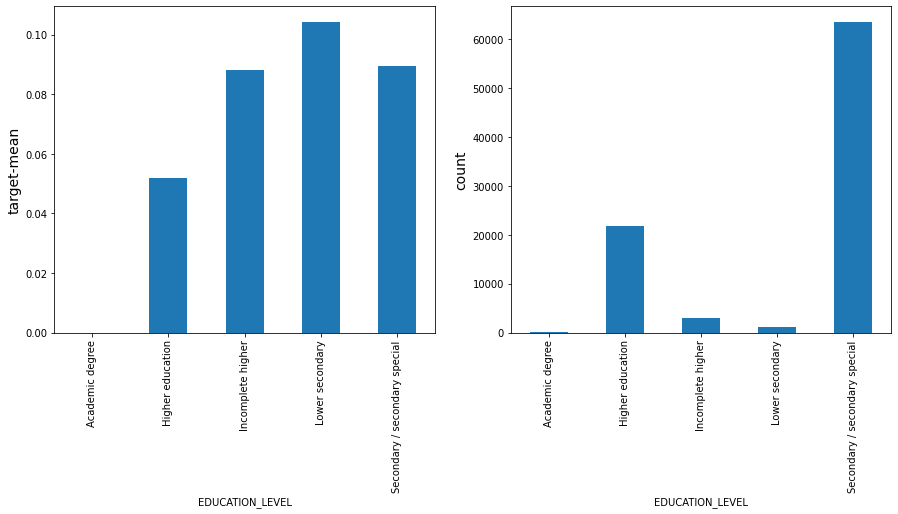

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


lower secondary и incomplete higher сильно выбиваются.

Text(0, 0.5, 'count')

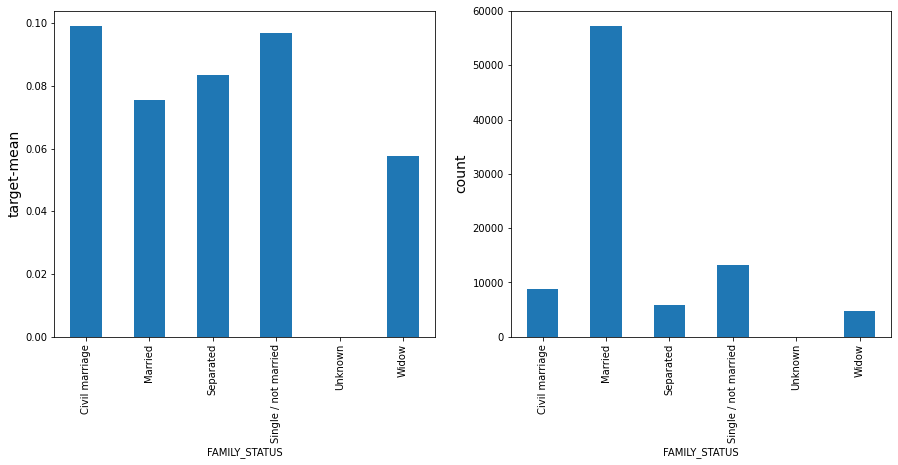

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


In [62]:
class FeatureImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        df['FAMILY_STATUS'].fillna('Unknown', inplace=True)
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
            cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        df["DAYS_ON_LAST_JOB"] = df["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
        bki_flags = [flag for flag in df.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
        df["bki_requests_count"] = df[bki_flags].sum(axis=1)
        df["bki_kurtosis"] = df[bki_flags].kurtosis(axis=1)

        df["external_scoring_prod"] = df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"]
        df["external_scoring_weighted"] = df.EXTERNAL_SCORING_RATING_1 * 2 + df.EXTERNAL_SCORING_RATING_2 * 1 + df.EXTERNAL_SCORING_RATING_3 * 3

        for function_name in ["min", "max", "mean", "nanmedian", "var"]:
            feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
            df[feature_name] = eval("np.{}".format(function_name))(
                df[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
            )

        # Отношение между основными фин. показателями
        df['ratio_credit_to_annuity'] = df['AMOUNT_CREDIT_y'] / df['AMOUNT_ANNUITY_y']
        df["ratio_annuity_to_salary"] = df['AMOUNT_ANNUITY_y'] / df['TOTAL_SALARY']
        df['ratio_credit_to_salary'] = df['AMOUNT_CREDIT_y'] / df['TOTAL_SALARY']
        df['ratio_salary_to_annuity'] = df['TOTAL_SALARY'] / df['AMOUNT_ANNUITY_y']

        
        # Отношение фин. показателей к возрасту и временным фичам
        df["ratio_annuity_to_age"] = df["AMOUNT_ANNUITY_y"] / df["AGE"]
        df["ratio_credit_to_age"] = df["AMOUNT_CREDIT_y"] / df["AGE"]
        df["ratio_salary_to_age"] = df["TOTAL_SALARY"] / df["AGE"]
        df["ratio_salary_to_experience"] = df["TOTAL_SALARY"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_credit_to_experience"] = df["AMOUNT_CREDIT_y"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_annuity_to_experience"] = df["AMOUNT_ANNUITY_y"] / df["DAYS_ON_LAST_JOB"]
        df['ratio_salary_to_family'] = df['TOTAL_SALARY'] / df['FAMILY_SIZE']


        # Отношение врменных признаков
        df["ratio_age_to_experience"] = df["AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_salary_to_region_population"] = df["TOTAL_SALARY"] * df["REGION_POPULATION"]
        df["ratio_car_to_experience"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_car_to_age"] = df["OWN_CAR_AGE"] / df["AGE"]

        # Произведение фин. показателей кредита на вероятность дефолта
        # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
        df["expected_total_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_CREDIT_y"]
        df["expected_total_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_CREDIT_y"]
        df["expected_total_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_CREDIT_y"]
        df["expected_monthly_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_ANNUITY_y"]
        df["expected_monthly_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_ANNUITY_y"]
        df["expected_monthly_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_ANNUITY_y"]
        
        pca = PCA(n_components=1)
        N_1 = pca.fit_transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)
        pca.explained_variance_ratio_[:2].sum()

        df['N_1'] = N_1
        N_1 = pca.transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)


        pca = PCA(n_components=1)
        N_2 = pca.fit_transform(df.loc[:,['AMOUNT_ANNUITY_y', 'AMOUNT_CREDIT_y']].values)
        pca.explained_variance_ratio_[:2].sum()  

        df['N_2'] = N_2

        N_2 = pca.transform(df.loc[:,['AMOUNT_ANNUITY_y', 'AMOUNT_CREDIT_y']].values)
      
        return df

In [63]:
imputer = FeatureImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [64]:
df_train_merged

,APPLICATION_NUMBER,TARGET,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,N_1,N_2
0,123687442,0.0,7703.805176,68787.179688,67592.101562,4813.080078,68787.179688,1221.000000,86.666667,10.666667,...,0.006399,0.000699,599170.562500,552256.312500,612667.562500,17609.306641,16230.521484,18005.976562,-0.230097,270403.250000
1,123597908,1.0,27919.001953,331908.750000,434949.750000,0.000000,331908.750000,659.250000,38.750000,26.500000,...,0.004080,0.000572,261397.843750,292641.843750,277159.625000,12571.922852,14074.601562,13329.984375,-0.043693,-66683.914062
2,123526683,0.0,32538.476562,353857.500000,402818.250000,18814.500000,707715.000000,1423.166667,16.833333,18.000000,...,0.002488,0.000417,508329.125000,686869.875000,269722.593750,21536.289062,29100.494141,11427.289062,-0.040107,422751.968750
3,123710391,1.0,4237.694824,61206.750000,59661.000000,2250.000000,61206.750000,1151.500000,2058.500000,14.000000,...,NaN,0.000403,261788.593750,88829.187500,88386.882812,11597.336914,3935.167969,3915.573730,0.454019,-65963.593750
4,123590329,1.0,14583.623047,266842.000000,308073.500000,1462.500000,300197.250000,741.000000,55.777778,30.750000,...,0.004080,0.000572,261397.843750,292641.843750,277159.625000,12571.922852,14074.601562,13329.984375,-0.043694,-66683.914062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0.0,13051.197266,66922.867188,74327.398438,0.832500,66922.867188,1308.200000,1126.600000,7.200000,...,0.004080,0.000572,261397.843750,292641.843750,277159.625000,12571.922852,14074.601562,13329.984375,-0.043694,-66683.914062
110089,123672463,0.0,9349.533203,68150.523438,67411.382812,6643.649902,88595.687500,584.846154,26.692308,10.200000,...,0.006647,0.000856,142348.296875,127166.554688,156738.937500,6663.516113,5952.838379,7337.161621,0.015934,-315166.687500
110090,123723001,0.0,4000.297363,30363.750000,28244.250000,4281.750000,30363.750000,464.500000,156.000000,9.000000,...,0.004080,0.000572,261397.843750,292641.843750,277159.625000,12571.922852,14074.601562,13329.984375,-0.043694,-66683.914062
110091,123554358,0.0,24760.710938,299340.000000,327861.000000,0.000000,299340.000000,789.000000,66.000000,21.000000,...,0.060942,0.001466,670001.562500,667338.250000,572324.062500,32317.304688,32188.841797,27605.865234,-0.161212,440752.343750


In [65]:
#df_train_merged = df_train_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
#df_test_merged = df_test_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)

In [66]:
def plot_features_distribution(train: pd.DataFrame, test: pd.DataFrame, features):
    """
    Построение графика распределения признака на обучающем и тестовом наборе данных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    test: pandas.core.frame.DataFrame
        Тестовая выборка.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = len(features)//5, 5
    if len(features) % 5:
        n_rows += 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_rows, 10*n_cols))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train[feature], hist=False, color="#33137d")
        sns.distplot(test[feature], color="#007539", hist=False)


In [67]:
target = df_train_merged["TARGET"]
#df_train_merged = df_train_merged.drop(["TARGET"], axis=1)

In [68]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])
numerical_features
features = numerical_features.columns.tolist()


In [69]:
features

['APPLICATION_NUMBER',
 'TARGET',
 'AMOUNT_ANNUITY_x',
 'AMT_APPLICATION',
 'AMOUNT_CREDIT_x',
 'AMOUNT_PAYMENT',
 'AMOUNT_GOODS_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY',
 'CHILDRENS',
 'TOTAL_SALARY',
 'AMOUNT_CREDIT_y',
 'AMOUNT_ANNUITY_y',
 'REGION_POPULATION',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FAMILY_SIZE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',

In [70]:
#plot_features_distribution(df_train_merged, df_test_merged, features=features)

In [71]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 86 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   APPLICATION_NUMBER                 110093 non-null  int32  
 1   TARGET                             110093 non-null  float64
 2   AMOUNT_ANNUITY_x                   110093 non-null  float32
 3   AMT_APPLICATION                    110093 non-null  float32
 4   AMOUNT_CREDIT_x                    110093 non-null  float32
 5   AMOUNT_PAYMENT                     110093 non-null  float32
 6   AMOUNT_GOODS_PAYMENT               110093 non-null  float32
 7   DAYS_DECISION                      110093 non-null  float64
 8   SELLERPLACE_AREA                   110093 non-null  float64
 9   CNT_PAYMENT                        110093 non-null  float32
 10  DAYS_FIRST_DRAWING                 110093 non-null  float32
 11  DAYS_FIRST_DUE                     1100

В целом, за исключением ряда небольших отклонений, распределения в тестовой и обучающей выборке совпадают. 

In [72]:
#fig, axes = plt.subplots(17, 4, figsize=(50, 50))

#for num, feature in enumerate(features):
#    sns.kdeplot(df_train_merged.loc[target==1, feature], ax=axes[num//4, num%4], color="blue", label="target=1")
#    sns.kdeplot(df_train_merged.loc[target==0, feature], ax=axes[num//4, num%4], color="red", label="target=0")
#    sns.kdeplot(df_train_merged[feature], ax=axes[num//4, num%4], color="green", label="train")
#    axes[num//4, num%4].set_title(feature, fontsize=14)
 #plt.show()

In [73]:
correlation = df_train_merged.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                               1.000000
N_1                                  0.186778
EXTERNAL_SCORING_RATING_var          0.061397
ratio_car_to_age                     0.039006
ratio_car_to_experience              0.024239
                                       ...   
EXTERNAL_SCORING_RATING_min         -0.162035
external_scoring_prod               -0.170404
EXTERNAL_SCORING_RATING_nanmedian   -0.173989
external_scoring_weighted           -0.187810
EXTERNAL_SCORING_RATING_mean        -0.199136
Name: TARGET, Length: 86, dtype: float64

In [74]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=500,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds



In [75]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, df_train_merged = df_train_merged["TARGET"], df_train_merged.drop(["TARGET"], axis=1)

In [76]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_merged, target, cv
)

Tue Dec 22 20:24:08 2020, Cross-Validation, 110093 rows, 85 cols
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.722732	valid_0's binary_logloss: 0.270778
[100]	valid_0's auc: 0.724484	valid_0's binary_logloss: 0.26496
[150]	valid_0's auc: 0.72609	valid_0's binary_logloss: 0.261294
[200]	valid_0's auc: 0.728562	valid_0's binary_logloss: 0.258802
[250]	valid_0's auc: 0.728864	valid_0's binary_logloss: 0.257093
[300]	valid_0's auc: 0.729443	valid_0's binary_logloss: 0.255838
[350]	valid_0's auc: 0.730184	valid_0's binary_logloss: 0.254912
[400]	valid_0's auc: 0.73071	valid_0's binary_logloss: 0.254198
[450]	valid_0's auc: 0.731271	valid_0's binary_logloss: 0.253672
[500]	valid_0's auc: 0.732384	valid_0's binary_logloss: 0.253167
[550]	valid_0's auc: 0.733753	valid_0's binary_logloss: 0.252651
[600]	valid_0's auc: 0.7351	valid_0's binary_logloss: 0.252235
[650]	valid_0's auc: 0.736428	valid_0's binary_logloss: 0.251855
[700]	valid_0's auc: 0.737599	vali

[200]	valid_0's auc: 0.701172	valid_0's binary_logloss: 0.26057
[250]	valid_0's auc: 0.701946	valid_0's binary_logloss: 0.259338
[300]	valid_0's auc: 0.702766	valid_0's binary_logloss: 0.258505
[350]	valid_0's auc: 0.703352	valid_0's binary_logloss: 0.257899
[400]	valid_0's auc: 0.703267	valid_0's binary_logloss: 0.257482
[450]	valid_0's auc: 0.703633	valid_0's binary_logloss: 0.257221
[500]	valid_0's auc: 0.704561	valid_0's binary_logloss: 0.256905
[550]	valid_0's auc: 0.705573	valid_0's binary_logloss: 0.256674
[600]	valid_0's auc: 0.706783	valid_0's binary_logloss: 0.256434
[650]	valid_0's auc: 0.707447	valid_0's binary_logloss: 0.256261
[700]	valid_0's auc: 0.70847	valid_0's binary_logloss: 0.256062
[750]	valid_0's auc: 0.709122	valid_0's binary_logloss: 0.255943
[800]	valid_0's auc: 0.709661	valid_0's binary_logloss: 0.255853
[850]	valid_0's auc: 0.710372	valid_0's binary_logloss: 0.255763
[900]	valid_0's auc: 0.71074	valid_0's binary_logloss: 0.255717
[950]	valid_0's auc: 0.71092

[500]	valid_0's auc: 0.704256	valid_0's binary_logloss: 0.251809
[550]	valid_0's auc: 0.705983	valid_0's binary_logloss: 0.251417
[600]	valid_0's auc: 0.706938	valid_0's binary_logloss: 0.251156
[650]	valid_0's auc: 0.707472	valid_0's binary_logloss: 0.250953
[700]	valid_0's auc: 0.708466	valid_0's binary_logloss: 0.250728
[750]	valid_0's auc: 0.709126	valid_0's binary_logloss: 0.250571
[800]	valid_0's auc: 0.710045	valid_0's binary_logloss: 0.250375
[850]	valid_0's auc: 0.710442	valid_0's binary_logloss: 0.250268
[900]	valid_0's auc: 0.711085	valid_0's binary_logloss: 0.25019
[950]	valid_0's auc: 0.711162	valid_0's binary_logloss: 0.250154
[1000]	valid_0's auc: 0.711654	valid_0's binary_logloss: 0.25009
[1050]	valid_0's auc: 0.71221	valid_0's binary_logloss: 0.250031
[1100]	valid_0's auc: 0.71244	valid_0's binary_logloss: 0.250017
[1150]	valid_0's auc: 0.712752	valid_0's binary_logloss: 0.249996
[1200]	valid_0's auc: 0.712831	valid_0's binary_logloss: 0.249985
[1250]	valid_0's auc: 0.

In [77]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7215


In [78]:
categorial = df_train_merged.dtypes[df_train_merged.dtypes == "object"].index
numerical = list(set(df_train_merged.columns) - set(categorial))

y_pred1 = np.zeros(df_test_merged.shape[0])
df_test_merged[numerical] = df_test_merged[numerical].astype(float)
df_test_merged[categorial] = df_test_merged[categorial].astype(str)

for estimator in estimators:
    y_pred1 += estimator.predict_proba(df_test_merged)[:, 1]


In [79]:
test_id = df_test["APPLICATION_NUMBER"]

y_pred1 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred1 / cv.n_splits
})

In [80]:
x_train, x_valid = train_test_split(
    df_train_merged.drop(["APPLICATION_NUMBER"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [81]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.708684	valid_0's binary_logloss: 0.273981
[100]	valid_0's auc: 0.710812	valid_0's binary_logloss: 0.268614
[150]	valid_0's auc: 0.711517	valid_0's binary_logloss: 0.265266
[200]	valid_0's auc: 0.712415	valid_0's binary_logloss: 0.263106
[250]	valid_0's auc: 0.713093	valid_0's binary_logloss: 0.261614
[300]	valid_0's auc: 0.714026	valid_0's binary_logloss: 0.260569
[350]	valid_0's auc: 0.715073	valid_0's binary_logloss: 0.259824
[400]	valid_0's auc: 0.715637	valid_0's binary_logloss: 0.259336
[450]	valid_0's auc: 0.71586	valid_0's binary_logloss: 0.258941
[500]	valid_0's auc: 0.716735	valid_0's binary_logloss: 0.25863
[550]	valid_0's auc: 0.717238	valid_0's binary_logloss: 0.25838
[600]	valid_0's auc: 0.717979	valid_0's binary_logloss: 0.258175
[650]	valid_0's auc: 0.718747	valid_0's binary_logloss: 0.257949
[700]	valid_0's auc: 0.719733	valid_0's binary_logloss: 0.257694
[750]	valid_0's auc: 0.720595	va

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [82]:
from copy import deepcopy

lgb_params = deepcopy(params)
lgb_params["n_estimators"] = 100

model = lgb.LGBMClassifier(**params)
model.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [83]:
y_score = model.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.7106


In [ ]:
x_valid_, y_valid_ = x_valid.sample(5000), y_valid.sample(5000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)


In [ ]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [ ]:
df_train_merged.columns


In [ ]:
to_drop2 = ['EDUCATION_LEVEL_Academic degree',  'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'GENDER_XNA', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'EDUCATION_LEVEL_Lower secondary', 'FAMILY_STATUS_Unknown', 'EDUCATION_LEVEL_Incomplete higher', 'CNT_CREDIT_PROLONG','FAMILY_STATUS_Widow', 'FLAG_EMAIL', 'AMT_REQ_CREDIT_BUREAU_MON', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'FAMILY_STATUS_Separated', 'CHILDRENS', 'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Single / not married', 'FLAG_PHONE', 'FAMILY_SIZE', 'DAYS_FIRST_DRAWING', 'TOTAL_SALARY', 'AMT_CREDIT_SUM_LIMIT', 'NUM_INSTALMENT_VERSION', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'expected_total_loss_1', 'NFLAG_INSURED_ON_APPROVAL', 'AMT_PAYMENT', 'AMOUNT_CREDIT_y', 'ratio_credit_to_salary', 'expected_total_loss_2', 'AMT_CREDIT_SUM_DEBT', 'DAYS_INSTALMENT', 'bki_requests_count', 'expected_total_loss_3', 'AMOUNT_GOODS_PAYMENT',  'expected_monthly_loss_3', 'ratio_credit_to_experience', 'AMT_ANNUITY', 'GENDER_F']
to_drop2

to_drop3 = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(60)['name'])
to_drop3

In [ ]:
fdsfsdfsdfsfd

In [ ]:
x_train_shap = x_train.drop(to_drop2, axis=1)
x_valid_shap = x_valid.drop(to_drop2, axis=1)

In [ ]:
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train_shap, y_train,
        eval_set=[(x_valid_shap, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

In [ ]:
df_train_shap = df_train_merged.drop(to_drop2, axis=1)
df_test_shap = df_test_merged.drop(to_drop2, axis=1)



In [ ]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 5000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
#target, target, df_train_shap

In [ ]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_shap, target, cv
)

In [ ]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

In [ ]:
categorial = df_train_shap.dtypes[df_train_shap.dtypes == "object"].index
numerical = list(set(df_train_shap.columns) - set(categorial))

y_pred2 = np.zeros(df_test_shap.shape[0])
df_test_shap[numerical] = df_test_shap[numerical].astype(float)
df_test_shap[categorial] = df_test_shap[categorial].astype(str)

for estimator in estimators:
    y_pred2 += estimator.predict_proba(df_test_shap)[:, 1]
    
test_id = df_test["APPLICATION_NUMBER"]

y_pred2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred2 / cv.n_splits
})

In [ ]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [ ]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [ ]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, df_train_merged, target, xgb_cv
)

In [ ]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

In [ ]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds_lgbm,
    "xgb_numerical": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [ ]:
y_pred_xgb = np.zeros(df_test_merged.shape[0])
dtest = xgb.DMatrix(data=df_test_merged)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)
    
y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb / cv.n_splits
})

In [ ]:
x_train, x_valid = train_test_split(
    df_train_merged, train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [ ]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 600,
    "reg_lambda": 100,
    "max_depth": 7,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
    'colsample_bytree': 0.555,
    'min_child_weights': 369
}

In [ ]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [ ]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

In [ ]:

train_score = roc_auc_score(y_train, model_xgb.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

In [ ]:
y_pred_xgb_model = model_xgb.predict(xgb.DMatrix(data=df_test_merged))
y_pred_xgb_model = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_test_x.flatten(),})
y_pred_xgb_model["APPLICATION_NUMBER"] = y_pred_xgb_model["APPLICATION_NUMBER"].astype(int)

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(dvalid, y_valid)
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [ ]:
to_drop = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(60)['name'])
to_drop

In [ ]:
x_train_shap = x_train.drop(to_drop, axis=1)
x_valid_shap = x_valid.drop(to_drop, axis=1)

In [ ]:
dtrain = xgb.DMatrix(x_train_shap, label=y_train)
dvalid = xgb.DMatrix(x_valid_shap, label=y_valid)

In [ ]:
xgb_estimators2, _, xgb_oof2 = xgboost_cross_validation(
    xgb_params, df_train_merged.drop(to_drop, axis=1), target, xgb_cv
)

In [ ]:
score = roc_auc_score(target, xgb_oof2)
print(f"Score = {round(score, 4)}")

In [ ]:
y_pred_xgb2 = np.zeros(df_test_merged.drop(to_drop, axis=1).shape[0])
dtest = xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1))

for estimator in xgb_estimators2:
    y_pred_xgb2 += estimator.predict(dtest)
    
y_pred_xgb2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb2 / cv.n_splits
})

In [ ]:
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

In [ ]:

train_score = roc_auc_score(y_train, model_xgb2.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb2.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

In [ ]:
y_pred_xgb_model2 = model_xgb2.predict(xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1)))
y_pred_xgb_model2 = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_test_x.flatten(),})
y_pred_xgb_model2["APPLICATION_NUMBER"] = y_pred_xgb_model2["APPLICATION_NUMBER"].astype(int)

In [ ]:
res = y_pred1.copy()
res['TARGET'] = (y_pred1['TARGET'] + y_pred2['TARGET'] + y_pred_xgb2['TARGET'] + y_pred_xgb_model['TARGET']) / 4
res.head()
res.to_csv("Kaldin_res_11.csv", index=False)

In [ ]:
y_pred1 - Score = 0.7263
y_pred2 - Score = 0.7277
y_pred_xgb - Score = 0.7259
y_pred_xgb2 - Score = 0.7275
y_pred_xgb_model - Valid-score: 0.727
y_pred_xgb_model2 - Valid-score: 0.726